### Verify that pytorch-geometric is correctly installed

If the notebook crashes at the import, there is likely an issue with the version of torch_geometric and torch_sparse being incompatible with the torch version.

In [1]:
## Verify that pytorch-geometric is correctly installed
import torch
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import numpy as np

## Load model
This steps takes a few minutes for the model to download.

**UPDATE**: It is important to set the model in eval mode through `model = model.eval()` to disable random dropout for optimal performance.

In [2]:
import esm
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.to('cuda')
model = model.eval()

#google how to transfer model onto gpu
#something like model = model.to('cuda')

/home/gkannan/anaconda3/envs/inverse-test/lib/python3.9/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [13]:
!nvidia-smi

Wed Aug 31 20:32:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:00.0 Off |                    0 |
|  0%   43C    P0    78W / 300W |   1351MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:43:00.0 Off |                    0 |
|  0%   

## Load structure from PDB or CIF files


In [ ]:
!wget https://files.rcsb.org/download/6VXX.pdb -P data/    # save this to the data folder in colab

Load chain from PDB file:

In [6]:
fpath = 'data/6M0J.pdb' # .pdb format is also acceptable
chain_id = 'E'
structure = esm.inverse_folding.util.load_structure(fpath, chain_id)
coords, native_seq = esm.inverse_folding.util.extract_coords_from_structure(structure)
print('Native sequence:')
print(native_seq)
print(len(native_seq))

Found 2 chains: ['A' 'E'] 

Loaded chain E

Native sequence:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG
194


## Calculate all possible mutations in a protein

To do this, we define the 'template' sequence - the full sequence of what we want to analyze. For example, this can be the SARS-CoV-2 spike. Then, we define the 'mutating' sequence - the section of that that we want to mutate. This could be the RBD. If both are the same, we mutate and analyze the full RBD.

In [1]:
#Calculating all possible mutants in protein

#RBD:
wuhan = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
alpha = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
delta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
beta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
eta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'

wt_6vxx_spike = 'AYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVNCTFEYVSFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKGNYNYLYRKPFERDIYFPLQSYGFQPTNVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTSQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDS'
wt_6vxx_ntd = 'AYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVNCTFEYVSFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQT'

## Why am I not using the full RBD/spike/etc.? The model won't allow me - it only takes into account lengths if they match the native sequence in the pdb.


chosenseq = eta  #The template sequence - i.e. if you want to run full spike but mutate RBD, this is full spike.
chosenseqname = 'eta'  
choosemutseq = eta   #The sequence you want to mutate - for example, RBD in full spike
startpoint = 0   #The AA residue (indexed at 0) that the mutated sequence starts at in template.
true_index = 333 #The true start of the sequence in the FL spike protein; for RBD this is 333, for NTD this is 14


seq = list(chosenseq)
aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

seq2 = seq.copy()
muts = {'WT': "".join(seq)}

for i in range(startpoint,startpoint+len(choosemutseq)):
  for j in aalist:
    seq2[i] = j
    muts.update({str(i)+j:"".join(seq2)})
    seq2 = seq.copy()


In [4]:
#Saving in /data folder

output_path = 'data/all_mutant_list_'+chosenseqname+'.txt'
output_file = open(output_path,'w')

for seq_id, sequence in muts.items():
    identifier_line = ">" + seq_id + "\n"
    output_file.write(identifier_line)
    sequence_line = sequence + "\n"
    output_file.write(sequence_line)
    
#Close the file when we're done
output_file.close()

## Conditional sequence log-likelihoods for given backbone coordinates

The log-likelihood scores could be used to predict mutational effects. See also our [script](https://github.com/facebookresearch/esm/tree/main/examples/inverse_folding#scoring-sequences) for batch scoring,

In [5]:
mutantlistname = 'data/all_mutant_list_'+chosenseqname+'.txt'
ll_list_name = 'data/mutant_list_lls'+chosenseqname+'_mc.csv'

!python score_log_likelihoods2.py data/6M0J.pdb \
    $mutantlistname --chain E --multichain-backbone\
    --outpath $ll_list_name

/home/gkannan/anaconda3/envs/inverse-test/lib/python3.9/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(
Native sequence loaded from structure file:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG


Native sequence
Log likelihood: -1.21
Perplexity: 3.35

Scoring variant sequences from sequence file..

100%|███████████████████████████████████████| 3881/3881 [32:42<00:00,  1.98it/s]
Results saved to data/mutant_list_llseta_mc.csv


## Analysis

At this point we have all mutations & the associated log-likelihood outputs from the model.

In [2]:
#Read in data, make new dataframes

import pandas as pd
import numpy as np

aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

#Read in data as dataframe

all_mutants_df=pd.read_table("data/all_mutant_list.txt", sep=" ", header=None)
all_mutants_Eta_df=data=pd.read_table("data/all_mutant_list_eta.txt", sep=" ", header=None)
all_mutants_df.insert(1,'sequence','')
all_mutants_Eta_df.insert(1,'sequence','')
all_mutants_delta_df=pd.read_table("data/all_mutant_list_delta.txt", sep=" ", header=None)
all_mutants_delta_df.insert(1,'sequence','')

#Split dataframe into mutation & sequence

mutants_df = pd.DataFrame({'mutation':all_mutants_df[0].iloc[::2].values, 'sequence':all_mutants_df[0].iloc[1::2].values})
Eta_df = pd.DataFrame({'mutation':all_mutants_Eta_df[0].iloc[::2].values, 'sequence':all_mutants_Eta_df[0].iloc[1::2].values})
delta_df = pd.DataFrame({'mutation':all_mutants_delta_df[0].iloc[::2].values, 'sequence':all_mutants_delta_df[0].iloc[1::2].values})

#Read in mutation & log likelihood

mlistll=pd.read_csv("data/mutant_list_lls.csv", sep=",", header=0)
mlistEtall=data=pd.read_csv("data/mutant_list_llseta_mc.csv", sep=",", header=0)
mlistdeltall=data=pd.read_csv("data/mutant_list_lls_delta.csv", sep=",", header=0)


In [3]:
#Add likelihoods to main dataframes, and normalize

mutants_df['log likelihood'] = mlistll['log_likelihood']
Eta_df['log likelihood'] = mlistEtall['log_likelihood']
delta_df['log likelihood'] = mlistdeltall['log_likelihood']

mutants_df['likelihood'] = np.exp(mutants_df['log likelihood'])# -np.exp(-1.1953586339950562) #Centers them around 0 = basis sequence
Eta_df['likelihood'] = np.exp(Eta_df['log likelihood'])# -np.exp(-1.2073875665664673)
delta_df['likelihood'] = np.exp(delta_df['log likelihood'])# -np.exp(-1.2177070379257202)

In [4]:
### See how model computes log likelihood

In [5]:
#Distance metric

Eta_df['ll_ratio'] = (Eta_df['log likelihood'] - -1.2073875665664673) - (mutants_df['log likelihood'] - -1.1953586339950562)
delta_df['ll_ratio'] = (delta_df['log likelihood'] - -1.2177070379257202) - (mutants_df['log likelihood'] - -1.1953586339950562)



<AxesSubplot:>

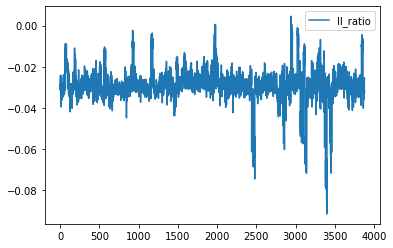

In [6]:
#Plot ratio as is

Eta_df.plot(y='ll_ratio')

In [7]:
#Split > off of mutation
Eta_df['mutation'] = Eta_df['mutation'].map(lambda x: x.lstrip('>'))
mutants_df['mutation'] = mutants_df['mutation'].map(lambda x: x.lstrip('>'))
delta_df['mutation'] = delta_df['mutation'].map(lambda x: x.lstrip('>'))

#Copy mutation to column index

Eta_df['index']=Eta_df['mutation']
mutants_df['index']=mutants_df['mutation']
delta_df['index']=delta_df['mutation']

#Remove wild type sequence (first one)

Eta_df_noWT = Eta_df.copy()
Eta_df_noWT = Eta_df_noWT.iloc[1: , :]

mutants_df_noWT = mutants_df.copy()
mutants_df_noWT = mutants_df_noWT.iloc[1: , :]

delta_df_noWT = delta_df.copy()
delta_df_noWT = delta_df_noWT.iloc[1: , :]

#Remove index from mutation column, and amino acid from index column.
#This gives us one column defining index & one column defining the amino acid at that position.

Eta_df_noWT['mutation'] = Eta_df_noWT['mutation'].str.replace('\d+', '')
Eta_df_noWT['index'] = Eta_df_noWT['index'].str.replace(str(aalist), '')

mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')

delta_df_noWT['mutation'] = delta_df_noWT['mutation'].str.replace('\d+', '')
delta_df_noWT['index'] = delta_df_noWT['index'].str.replace(str(aalist), '')

/tmp/ipykernel_1080551/1883783669.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  Eta_df_noWT['mutation'] = Eta_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_1080551/1883783669.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  Eta_df_noWT['index'] = Eta_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_1080551/1883783669.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_1080551/1883783669.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_1080551/1883783669.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  delta_d

In [8]:
#Shift index to true index; i.e. change position 0 to position 333 for RBD.

true_index = 333

Eta_df_noWT['index'] = pd.to_numeric(Eta_df_noWT['index'])
Eta_df_noWT['index'] = Eta_df_noWT['index'] + true_index

delta_df_noWT['index'] = pd.to_numeric(delta_df_noWT['index'])
delta_df_noWT['index'] = delta_df_noWT['index'] + true_index

#result here is a pivot table of ll_ratio, other pivot tables are of just likelihood

result = Eta_df_noWT.pivot_table(index='mutation', columns='index', values='ll_ratio',sort=False)

mutants_df_noWT['index'] = pd.to_numeric(mutants_df_noWT['index'])
mutants_df_noWT['index'] = mutants_df_noWT['index'] + true_index

#Create a pivot table w/ index on x and mutation on y

result_mut = mutants_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

result_Eta = Eta_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

result_delta = delta_df_noWT.pivot_table(index='mutation', columns='index', values='ll_ratio',sort=False)

result_delta_only = delta_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

In [9]:
#Normalize columns to 1

for column in result_Eta:
    result_Eta[column] = result_Eta[column]/result_Eta[column].sum()

for column in result_mut:
    result_mut[column] = result_mut[column]/result_mut[column].sum()


In [10]:
#Ship to excel

result_Eta.to_excel('data/result_Eta.xlsx')

# Comparing Eta and Wuhan

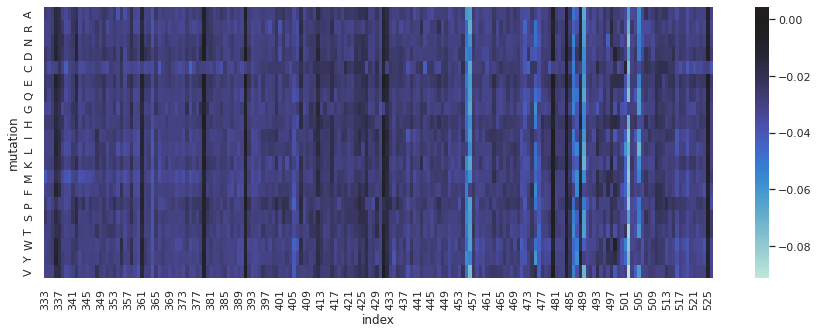

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result, annot=False, cmap='icefire',center=0)
plt.show()

#Heatmap of ll_ratio

In [12]:
#### NA THE 501 POSITION ABOVE

### Ian Wilson group Nat Comm Flu epistasis deep mutational scanning 2020 7 diff flu-HA backgrounds all possible amino acid changes at like 6 sites

### make sure i'm using gpu compute lmao

### Figure out if JSD is using softmax to make it probabilities -> making it jensen shannon

<AxesSubplot:xlabel='index'>

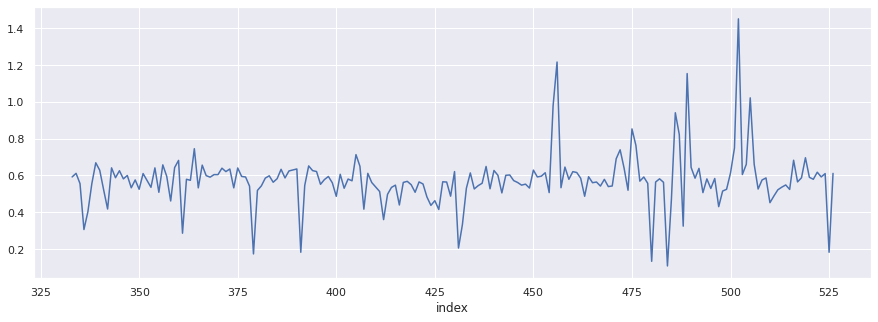

In [13]:
#Quick & dirty quantification - vertical sum of absolute values of heatmap

result_abs = abs(result)
resultsum = result_abs.sum()
resultsum.plot()

# Wuhan/Variants Heatmaps

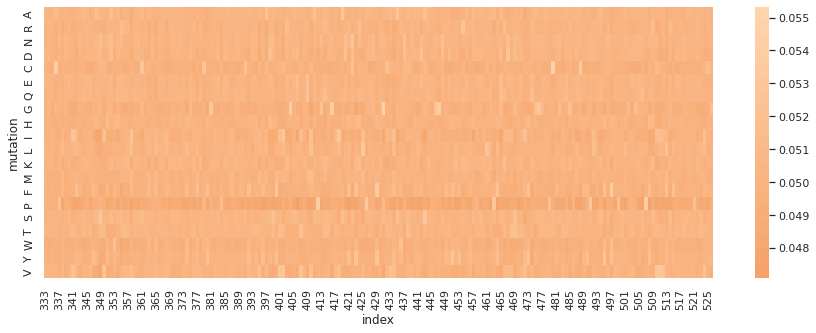

In [14]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_mut, annot=False, cmap='icefire',center=0)
plt.show()
#Wuhan

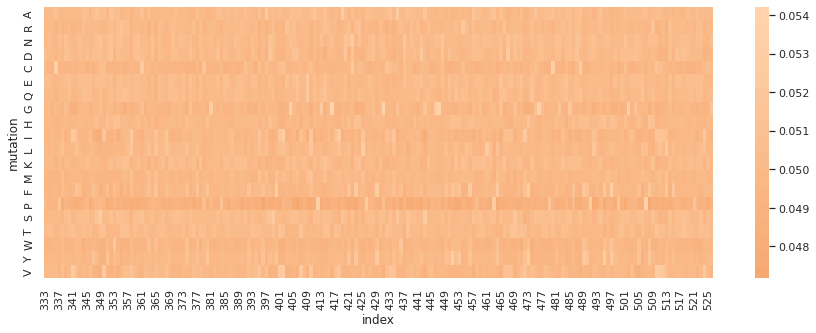

In [15]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_Eta, annot=False, cmap='icefire',center=0)
plt.show()
#N501Y

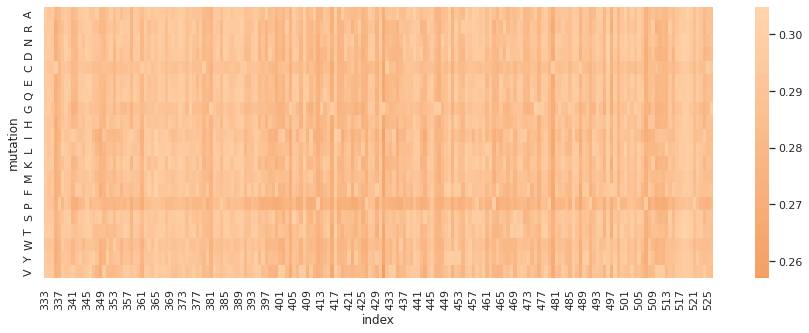

In [16]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_delta_only, annot=False, cmap='icefire',center=0)
plt.show()
#Delta

# Bloom Data

In [17]:
#Let's try a Spearman correlation with the JB expression data.

#First, let's import the data and separate it into dataframes for each variant.

jb_df = pd.read_csv('data/bloom_science_expr.csv')

In [18]:
#create unique list of names
VariantNames = jb_df.target.unique()

#create a data frame dictionary to store the data frames
bloom_data = {elem : pd.DataFrame() for elem in VariantNames}

for key in bloom_data.keys():
    bloom_data[key] = jb_df[:][jb_df.target == key]

In [19]:
#Pivot table to get each variant
bloom_Eta = bloom_data['E484K'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)
bloom_wuhan = bloom_data['Wuhan-Hu-1'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)
bloom_delta = bloom_data['Delta'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)

#Drop the first two columns and last five columns; these are cut out in the native sequence for esm-if1.
bloom_Eta = bloom_Eta.iloc[: , 2:196]
bloom_wuhan = bloom_wuhan.iloc[: , 2:196]
bloom_delta = bloom_delta.iloc[: , 2:196]


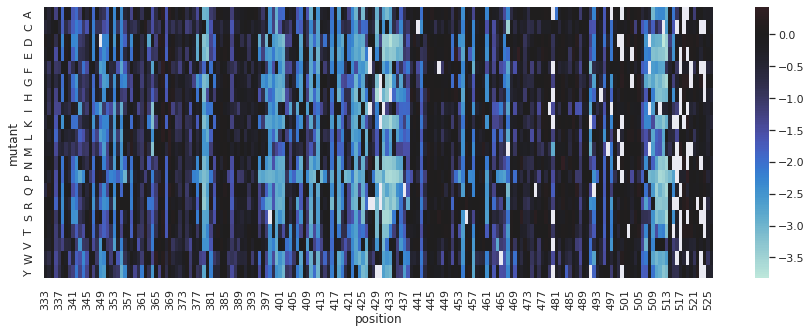

In [20]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(bloom_wuhan, annot=False, cmap='icefire',center=0)
plt.show()
#wuhan

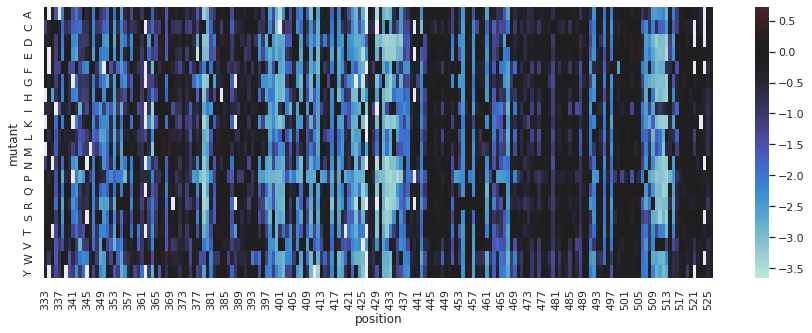

In [21]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(bloom_Eta, annot=False, cmap='icefire',center=0)
plt.show()
#N501Y

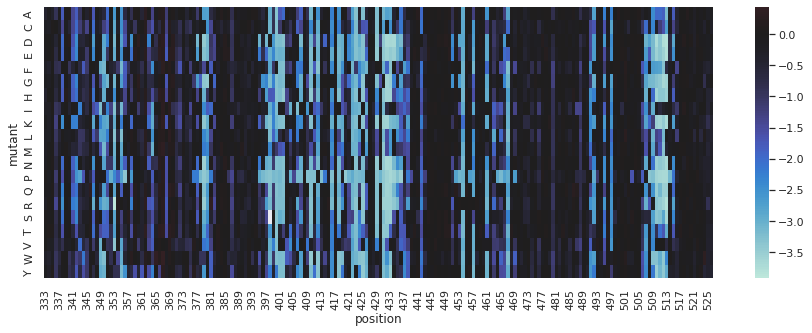

In [22]:
sns.set(rc = {'figure.figsize':(15,5)})

cmaptest = sns.diverging_palette(240, 0, s=100, sep=1 ,l=70, center='dark',as_cmap=True)

sns.heatmap(bloom_delta, annot=False, cmap='icefire',center=0)
plt.show()
#delta

In [23]:
#Now to actually try a spearman correlation; we need to put all the bloom delta expression and my data in one column each.

Eta_df_noWT_rn = Eta_df_noWT.copy()
Eta_df_noWT_rn = Eta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})

Eta_df_noWT_rn = Eta_df_noWT.copy()
Eta_df_noWT_rn = Eta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})

Eta_merged_df = Eta_df_noWT_rn.merge(bloom_data['E484K'],on = ['position', 'mutant'], how = 'left')

In [24]:
#All the same data processing for delta

delta_df_noWT_rn = delta_df_noWT.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
delta_merged_df = delta_df_noWT_rn.merge(bloom_data['Delta'],on = ['position', 'mutant'], how = 'left')


In [25]:
#Now the actual spearman correlation


corr_columns_Eta = Eta_merged_df[['likelihood','delta_expr']]

corr_columns_delta = delta_merged_df[['likelihood','expr']]


N501Y expression correlation

In [26]:
corr_columns_Eta.corr(method='spearman')

,likelihood,delta_expr
likelihood,1.000000,0.636118
delta_expr,0.636118,1.000000


<AxesSubplot:xlabel='likelihood'>

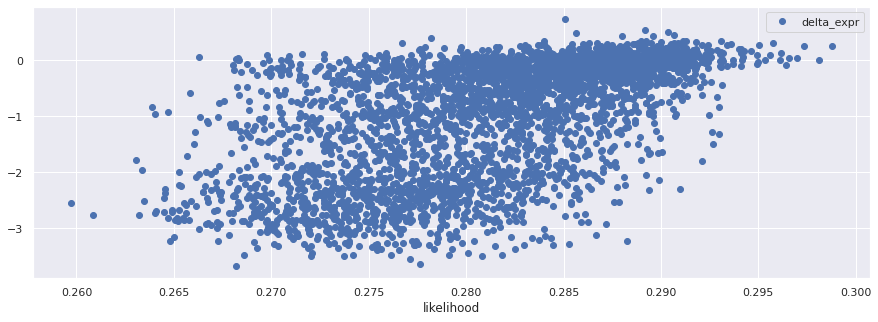

In [27]:
corr_columns_Eta.plot(x='likelihood',y='delta_expr',style='o')

Delta expression correlation

In [28]:
corr_columns_delta.corr(method='spearman')

,likelihood,expr
likelihood,1.00000,0.65381
expr,0.65381,1.00000


<AxesSubplot:xlabel='likelihood'>

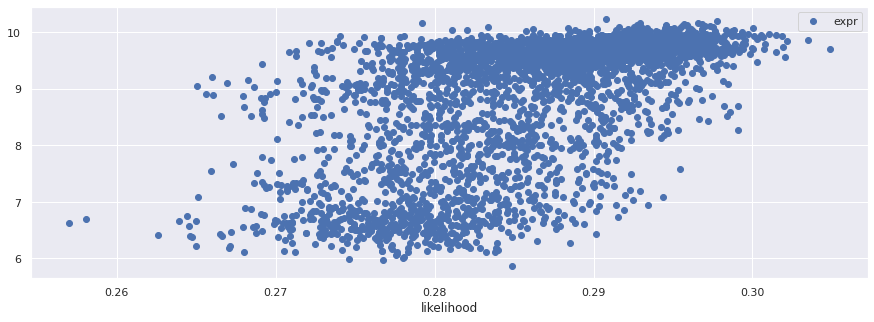

In [29]:
corr_columns_delta.plot(x='likelihood',y='expr',style='o')

Correlation for binding

In [30]:
corr_columns_Eta_bind = Eta_merged_df[['likelihood','bind']]
corr_columns_Eta_bind.corr(method='spearman')

,likelihood,bind
likelihood,1.000000,0.698786
bind,0.698786,1.000000


In [31]:
corr_columns_delta_bind = delta_merged_df[['likelihood','bind']]
corr_columns_delta_bind.corr(method='spearman')

,likelihood,bind
likelihood,1.000000,0.621878
bind,0.621878,1.000000


In [32]:
#Put bloom data as expr_ratio on same metric that we did for ESM outputs

bloom_data_Eta_expr = bloom_data['E484K'][['position','mutant','expr']]
bloom_data_Eta_expr['expr_ratio'] = np.log(bloom_data['E484K']['expr'].to_numpy()/10.14430) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


/tmp/ipykernel_1080551/4204946691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloom_data_Eta_expr['expr_ratio'] = np.log(bloom_data['E484K']['expr'].to_numpy()/10.14430) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


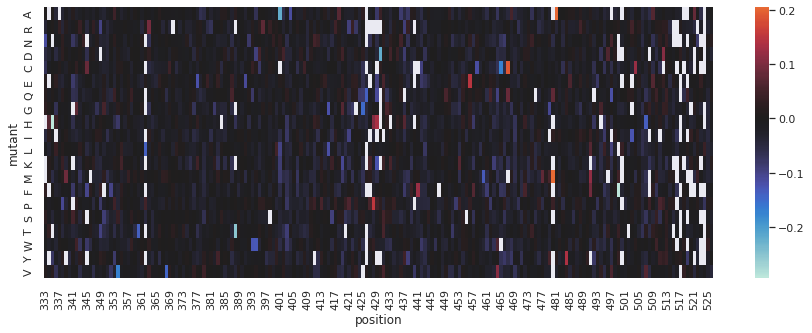

In [33]:
#Actual comparison for Eta with same metric

Eta_merged_df_2 = Eta_df_noWT_rn.merge(bloom_data_Eta_expr,on = ['position', 'mutant'], how = 'left')


bloom_pivot_Eta = Eta_merged_df_2.pivot_table(index='mutant', columns='position', values='expr_ratio',sort=False)

sns.heatmap(bloom_pivot_Eta, annot=False, cmap='icefire',center=0)
plt.show()


<AxesSubplot:xlabel='position'>

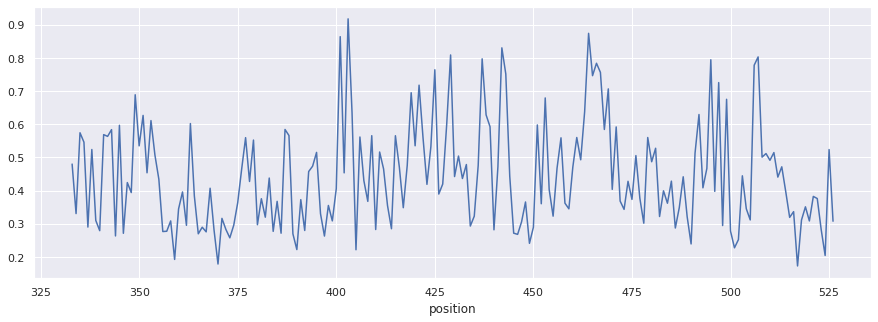

In [34]:
#Vertical sum for bloom data Eta comparison
bloom_pivot_Eta_abs = abs(bloom_pivot_Eta)
bloom_pivot_Eta_sum = bloom_pivot_Eta_abs.sum()
bloom_pivot_Eta_sum.plot()

In [35]:
Eta_df_noWT_rn = Eta_df_noWT.copy()
Eta_df_noWT_rn = Eta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
Eta_merged_df = Eta_df_noWT_rn.merge(bloom_data_Eta_expr,on = ['position', 'mutant'], how = 'left')

Correlating the epistatic shifts w/ both operated on the same way.

In [36]:
corr_columns_Eta_expr_ratio = Eta_merged_df[['ll_ratio','expr_ratio']]
corr_columns_Eta_expr_ratio.corr(method='spearman')

,ll_ratio,expr_ratio
ll_ratio,1.000000,-0.030768
expr_ratio,-0.030768,1.000000


<AxesSubplot:xlabel='ll_ratio'>

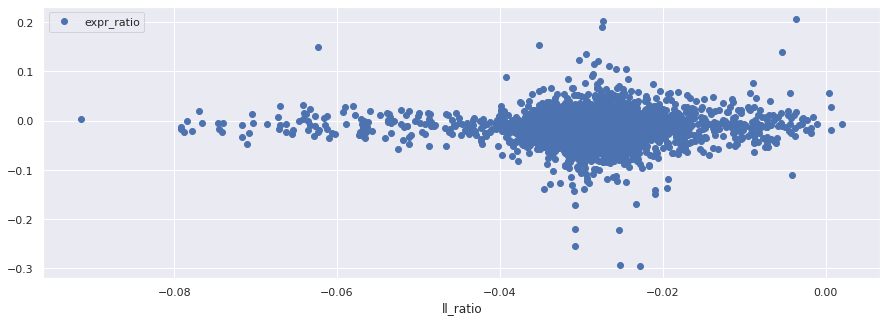

In [37]:
corr_columns_Eta_expr_ratio.plot(x='ll_ratio',y='expr_ratio',style='o')

In [38]:
#Going through the same process for Delta

bloom_data_Delta_expr = bloom_data['Delta'][['position','mutant','expr']]
bloom_data_Delta_expr['expr_ratio'] = np.log(bloom_data['Delta']['expr'].to_numpy()/9.79026) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)

delta_df_noWT_rn = delta_df_noWT_rn.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
Delta_merged_df = delta_df_noWT_rn.merge(bloom_data_Delta_expr,on = ['position', 'mutant'], how = 'left')

corr_columns_Delta_expr_ratio = Delta_merged_df[['ll_ratio','expr_ratio']]
corr_columns_Delta_expr_ratio.corr(method='spearman')

/tmp/ipykernel_1080551/3595949502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloom_data_Delta_expr['expr_ratio'] = np.log(bloom_data['Delta']['expr'].to_numpy()/9.79026) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


,ll_ratio,expr_ratio
ll_ratio,1.000000,0.041724
expr_ratio,0.041724,1.000000


Jensen-shannon divergence

In [39]:
result_mut_prob = result_mut.copy()
for column in result_mut_prob:
    colsum = np.exp(-np.log(result_mut_prob[column])).sum()
    result_mut_prob = result_mut_prob.applymap(lambda x: (np.exp(-np.log(x)))/colsum)

result_Eta_prob = result_Eta.copy()
for column in result_Eta_prob:
    colsum = np.exp(-np.log(result_Eta_prob[column])).sum()
    result_Eta_prob = result_Eta_prob.applymap(lambda x: (np.exp(-np.log(x)))/colsum)

    

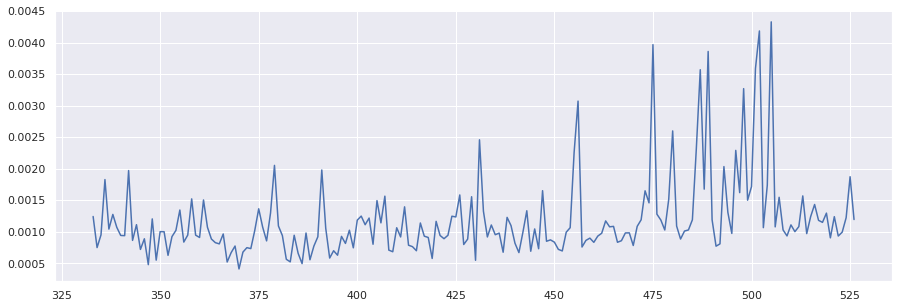

In [40]:
#Cycle through all positions, calculate JSD between results_Eta and result_mutant at each position
import scipy

jsd_Eta = []
columns=[]

for column in result_Eta:
    columns.append(column)
    jsd_Eta.append(scipy.spatial.distance.jensenshannon(result_Eta_prob[column],result_mut_prob[column]))
    
plt.plot(columns,jsd_Eta)

In [41]:
x = result_mut[498]
y = result_Eta[498]
#x = (x - x.min())/(x.max()-x.min())
#y = (y - y.min())/(y.max()-y.min())
print(scipy.spatial.distance.euclidean(x,y))

0.0020713647794676974


In [42]:
result_Eta

index,333,334,335,336,337,338,339,340,341,342,...,517,518,519,520,521,522,523,524,525,526
mutation,,,,,,,,,,,,,,,,,,,,,
A,0.050321,0.049996,0.050349,0.051114,0.050193,0.049865,0.050201,0.050257,0.050011,0.050190,...,0.049897,0.049942,0.050588,0.050257,0.050116,0.050597,0.050409,0.050002,0.050159,0.050064
R,0.049950,0.050299,0.050252,0.049412,0.050243,0.049310,0.049963,0.050174,0.049493,0.049769,...,0.050360,0.050019,0.049945,0.050169,0.049951,0.050451,0.050532,0.049412,0.050383,0.049916
N,0.049816,0.050480,0.050178,0.049796,0.050691,0.050187,0.050863,0.050314,0.049942,0.050119,...,0.050523,0.050748,0.050604,0.050129,0.050182,0.050463,0.050440,0.049831,0.049967,0.050470
D,0.050431,0.050307,0.050088,0.049786,0.050247,0.049885,0.050862,0.050643,0.050050,0.049706,...,0.050522,0.050838,0.050730,0.050150,0.050389,0.050379,0.050234,0.049138,0.049544,0.049828
C,0.050067,0.049324,0.049472,0.053016,0.049408,0.049815,0.049297,0.049354,0.049693,0.049289,...,0.049134,0.049465,0.049129,0.049131,0.048938,0.049565,0.049202,0.050152,0.050578,0.050074
E,0.050527,0.050482,0.050322,0.049762,0.050071,0.050022,0.050515,0.050856,0.050080,0.050000,...,0.050446,0.050312,0.050575,0.050667,0.050578,0.050676,0.050545,0.049776,0.049920,0.049892
Q,0.050268,0.050420,0.050202,0.049497,0.050171,0.050030,0.050227,0.050542,0.049835,0.049683,...,0.050388,0.050050,0.050302,0.050503,0.050250,0.050527,0.050535,0.049975,0.050201,0.050170
G,0.049925,0.050326,0.049267,0.050380,0.049957,0.049378,0.050536,0.049323,0.048618,0.048966,...,0.049287,0.049905,0.050083,0.049415,0.049328,0.049091,0.049170,0.049033,0.049479,0.051453
H,0.049924,0.050014,0.049840,0.049440,0.049969,0.049909,0.049996,0.049643,0.049662,0.049784,...,0.050258,0.050164,0.049858,0.049935,0.049984,0.049955,0.049763,0.049332,0.050102,0.049956


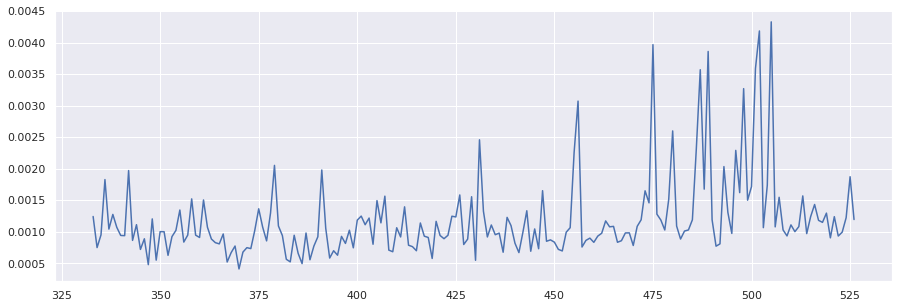

In [43]:
plt.plot(columns,jsd_Eta)

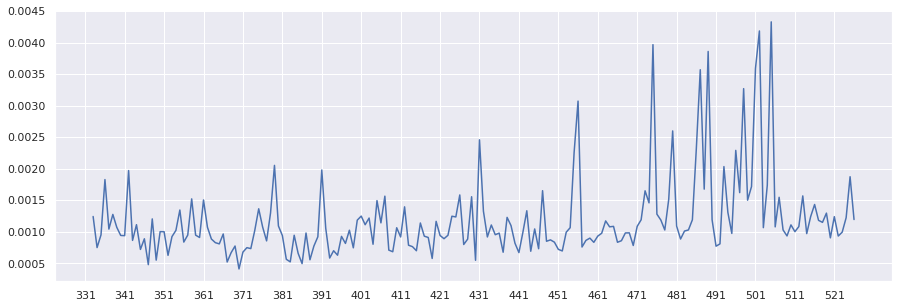

In [44]:
#Cycle through all positions, calculate JSD between results_Eta and result_mutant at each position

#This time did absolute values of each vector.

#You want JSD between pairs of columns.

import scipy

jsd_Eta = []
columns = []

for column in result_Eta:
    columns.append(column)
    jsd_Eta.append(scipy.spatial.distance.jensenshannon(result_Eta[column],result_mut[column]))
    
plt.plot(columns,scipy.spatial.distance.jensenshannon(abs(result_Eta),abs(result_mut),axis=0))

freq_x = 10

plt.xticks(np.arange(331, 531, freq_x))
plt.show()

In [45]:
bloom_data['E484K']

,target,wildtype,position,mutant,mutation,bind,delta_bind,n_bc_bind,n_libs_bind,bind_rep1,bind_rep2,bind_rep3,expr,delta_expr,n_bc_expr,n_libs_expr,expr_rep1,expr_rep2
4020,E484K,N,331,A,N331A,8.90703,-0.05404,5,3,8.73486,8.99604,8.99020,9.90342,-0.18769,3,2,9.88018,9.92666
4021,E484K,N,331,C,N331C,8.45682,-0.50425,8,3,8.37763,8.31686,8.67598,9.36353,-0.72758,5,2,9.05636,9.67071
4022,E484K,N,331,D,N331D,8.88297,-0.07810,6,3,8.70320,8.92708,9.01863,9.96798,-0.12314,4,2,10.04895,9.88701
4023,E484K,N,331,E,N331E,9.07924,0.06027,3,1,NaN,9.07924,NaN,10.00568,-0.14599,3,1,NaN,10.00568
4024,E484K,N,331,F,N331F,8.72462,-0.23645,8,3,8.66699,8.71465,8.79222,9.31892,-0.77219,5,2,9.21884,9.41900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,E484K,T,531,S,T531S,9.02914,0.06807,4,3,8.87888,9.17509,9.03344,10.10955,0.01844,3,2,10.17465,10.04445
8036,E484K,T,531,T,T531T,8.96107,0.00000,26917,3,8.82349,9.01897,9.04075,10.09111,0.00000,16451,2,10.03055,10.15167
8037,E484K,T,531,V,T531V,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
8038,E484K,T,531,W,T531W,8.97065,0.00958,5,3,8.60053,9.03263,9.27879,9.72562,-0.36549,3,2,9.50969,9.94155


In [46]:
#Importing binding and expression JSD from Bloom data as dataframes

binding_jsd_url = 'https://raw.githubusercontent.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/epistatic_shifts/JSD_versus_Wuhan1_by_target.csv'
expression_jsd_url = 'https://raw.githubusercontent.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/epistatic_shifts/JSD_versus_Wuhan1_EXPRESSION_by_target.csv'

binding_jsd_df = pd.read_csv(binding_jsd_url)
expression_jsd_df = pd.read_csv(expression_jsd_url)



In [47]:
#Selecting just Eta binding + those that bind > 1 stdev above mean (top ~7%)

binding_jsd_df_Eta = binding_jsd_df.loc[(binding_jsd_df['bg_1'] == 'Wuhan-Hu-1') & (binding_jsd_df['bg_2'] == 'E484K')]
mean_Eta = binding_jsd_df_Eta['JSD'].mean()
sd_Eta = binding_jsd_df_Eta['JSD'].std()


top_Eta_bind_df = binding_jsd_df_Eta[((binding_jsd_df_Eta['JSD'] > mean_Eta+sd_Eta))]

top_Eta_bind_df

,bg_1,bg_2,site,JSD,JSD_min3bc,JSD_min5bc
2,Wuhan-Hu-1,E484K,333,0.050307,0.013544,0.000000
6,Wuhan-Hu-1,E484K,337,0.100898,0.009412,0.010068
20,Wuhan-Hu-1,E484K,351,0.035031,0.035031,0.035031
22,Wuhan-Hu-1,E484K,353,0.069848,0.069848,0.025462
88,Wuhan-Hu-1,E484K,419,0.035420,0.033476,0.030369
94,Wuhan-Hu-1,E484K,425,0.067287,0.011499,0.011626
95,Wuhan-Hu-1,E484K,426,0.031896,0.020914,0.020914
98,Wuhan-Hu-1,E484K,429,0.042308,0.001757,0.001002
106,Wuhan-Hu-1,E484K,437,0.038475,0.038475,0.038475
107,Wuhan-Hu-1,E484K,438,0.041729,0.033896,0.007320


In [48]:
#Selecting just Eta expression + those that express > 1 stdev above mean (top ~12%)

expression_jsd_df_Eta = expression_jsd_df.loc[(expression_jsd_df['bg_1'] == 'Wuhan-Hu-1') & (expression_jsd_df['bg_2'] == 'E484K')]
mean_Eta_exp = expression_jsd_df_Eta['JSD'].mean()
sd_Eta_exp = expression_jsd_df_Eta['JSD'].std()

print(sd_Eta_exp)

top_Eta_expr_df = expression_jsd_df_Eta[((expression_jsd_df_Eta['JSD'] > mean_Eta_exp+sd_Eta_exp))]

top_Eta_expr_df

0.015147174467907993


,bg_1,bg_2,site,JSD,JSD_min3bc,JSD_min5bc
0,Wuhan-Hu-1,E484K,331,0.060358,0.052511,0.032497
2,Wuhan-Hu-1,E484K,333,0.056469,0.000000,0.000000
4,Wuhan-Hu-1,E484K,335,0.043952,0.005057,0.002771
18,Wuhan-Hu-1,E484K,349,0.073606,0.076740,0.069155
23,Wuhan-Hu-1,E484K,354,0.037336,0.028215,0.020836
52,Wuhan-Hu-1,E484K,383,0.038139,0.025555,0.009555
57,Wuhan-Hu-1,E484K,388,0.039891,0.013936,0.000733
72,Wuhan-Hu-1,E484K,403,0.041657,0.040496,0.037822
89,Wuhan-Hu-1,E484K,420,0.045417,0.032620,0.002377
96,Wuhan-Hu-1,E484K,427,0.055789,0.007272,0.007272


In [49]:
#Repeat for the calculated absolute value JSDs from LM data

jsd_abs = scipy.spatial.distance.jensenshannon(abs(result_Eta),abs(result_mut))
jsd_notabs = scipy.spatial.distance.jensenshannon(result_Eta,result_mut)
jsd_notabs_df = pd.DataFrame(jsd_notabs)
jsd_notabs_df['Index']=columns

jsd_abs_df = pd.DataFrame(jsd_abs)
jsd_abs_df['Index']=columns

mean_jsd_abs = jsd_abs_df[0].mean()
sd_jsd_abs = jsd_abs_df[0].std()

top_abs_jsd_df = jsd_abs_df[((jsd_abs_df[0] > mean_jsd_abs+sd_jsd_abs))]

top_abs_jsd_df

,0,Index
9,0.001973,342
46,0.002055,379
58,0.001982,391
98,0.002460,431
122,0.002258,455
123,0.003074,456
142,0.003968,475
147,0.002601,480
153,0.002320,486
154,0.003571,487


In [50]:
#Counting matches between expression & log likelihoods

count = 0

for i in top_abs_jsd_df['Index']:
    if (i in set(top_Eta_expr_df['site'])):
        count +=1
    #elif (i+1 in set(top_Eta_expr_df['site'])):
     #   count +=1
    #elif (i-1 in set(top_Eta_expr_df['site'])):
     #   count +=1

print('number of matches:')
print(count)
print('fraction of top sites found:')
print(count/len(top_Eta_expr_df))
print('fraction of predicted sites that are top sites:')
print(count/len(top_abs_jsd_df))

number of matches:
0
fraction of top sites found:
0.0
fraction of predicted sites that are top sites:
0.0


In [51]:
#Counting matches between binding & log likelihood jsd

count = 0

for i in top_abs_jsd_df['Index']:
    if (i in set(top_Eta_bind_df['site'])):
        count +=1
    #elif (i+1 in set(top_Eta_bind_df['site'])):
     #   count +=1
    #elif (i-1 in set(top_Eta_bind_df['site'])):
     #   count +=1

print('number of matches:')
print(count)
print('fraction of top sites found:')
print(count/len(top_Eta_bind_df))
print('fraction of predicted sites that are top sites:')
print(count/len(top_abs_jsd_df))

number of matches:
0
fraction of top sites found:
0.0
fraction of predicted sites that are top sites:
0.0


Now to do Spearman's rank correlation between JSD from language model (jsd_notabs_df) and JSD from Bloom data (expression_jsf_df_N501Y

In [52]:
#Just simplify the expression dataframe to what i need here
jsd_Eta = expression_jsd_df_Eta[['site','JSD']].copy()


In [53]:
#rename
jsd_notabs_df.columns = {'site' if x=='Index' else x for x in jsd_notabs_df.columns}

In [54]:
#renaming columns & merging dfs to one dataframe with site, LM jsd, and Bloom jsd
combined_jsd_df = pd.merge(jsd_notabs_df, jsd_Eta, on='site')
combined_jsd_df.columns = {'JSD_LM' if x==0 else x for x in combined_jsd_df.columns}
combined_jsd_df.columns = {'JSD_Eta' if x=='site' else x for x in combined_jsd_df.columns}
combined_jsd_df.columns = {'Index' if x=='JSD_LM' else x for x in combined_jsd_df.columns}


In [55]:
combined_jsd_df

,Index,JSD,JSD_Eta
0,0.001245,333,0.056469
1,0.000752,334,0.029632
2,0.000954,335,0.043952
3,0.001830,336,0.029717
4,0.001045,337,0.017161
...,...,...,...
189,0.000935,522,0.038043
190,0.000997,523,0.029552
191,0.001226,524,0.058118
192,0.001875,525,0.024100


In [56]:
def normalize(df):
    result = df.copy()
    
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

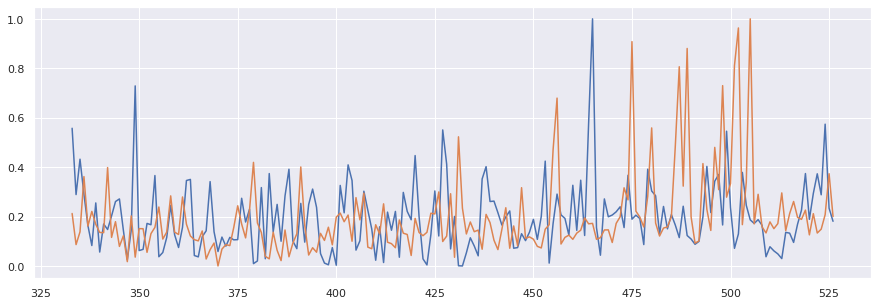

In [57]:
#Overlay the predicted and experimental JSD plots:

#plt.plot(combined_jsd_df['JSD'], ((combined_jsd_df['Index']-combined_jsd_df['Index'].mean())/combined_jsd_df['Index'].std()), label='line 1')
#plt.plot(combined_jsd_df['JSD'], ((combined_jsd_df['JSD_N501Y']-combined_jsd_df['JSD_N501Y'].mean())/combined_jsd_df['JSD_N501Y'].std()), label='line 2')

plt.plot(combined_jsd_df['JSD'], normalize(combined_jsd_df['JSD_Eta']), label='line 1')
plt.plot(combined_jsd_df['JSD'], normalize(combined_jsd_df['Index']), label='line 2')




In [58]:
#spearman correlation pt1
combined_jsd_df.corr(method='spearman')

scipy.stats.spearmanr(combined_jsd_df['JSD'],combined_jsd_df['JSD_Eta'])

SpearmanrResult(correlation=0.10787803084154773, pvalue=0.13433352377650848)

<AxesSubplot:>

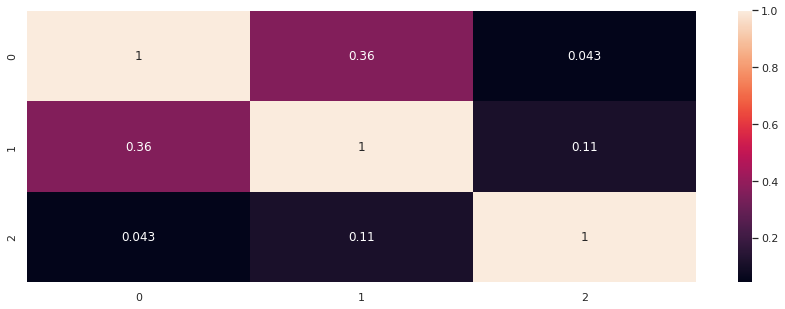

In [59]:
#spearman correlation attempt 2
corr_jsd,pval_corr_jsd = scipy.stats.spearmanr(jsd_notabs_df,jsd_Eta[2:196]['JSD'])
sns.heatmap(corr_jsd, annot = True)


In [60]:
#Manually doing Spearman correlation to check lol

combined_jsd_df_ranks = combined_jsd_df.rank()
combined_jsd_df['JSD_rank'] = combined_jsd_df_ranks['JSD']
combined_jsd_df['JSD_Eta_rank'] = combined_jsd_df_ranks['JSD_Eta']
combined_jsd_df['d'] = combined_jsd_df['JSD_rank']-combined_jsd_df['JSD_Eta_rank']
combined_jsd_df['d^2'] = combined_jsd_df['d']**2

rho = 1 - (6*(combined_jsd_df['d^2'].sum())/(len(combined_jsd_df)*(((len(combined_jsd_df))**2)-1)))
print(rho)
combined_jsd_df

0.10787803084154779


,Index,JSD,JSD_Eta,JSD_rank,JSD_Eta_rank,d,d^2
0,0.001245,333,0.056469,1.0,190.0,-189.0,35721.0
1,0.000752,334,0.029632,2.0,153.0,-151.0,22801.0
2,0.000954,335,0.043952,3.0,186.0,-183.0,33489.0
3,0.001830,336,0.029717,4.0,154.0,-150.0,22500.0
4,0.001045,337,0.017161,5.0,89.0,-84.0,7056.0
...,...,...,...,...,...,...,...
189,0.000935,522,0.038043,190.0,175.0,15.0,225.0
190,0.000997,523,0.029552,191.0,152.0,39.0,1521.0
191,0.001226,524,0.058118,192.0,191.0,1.0,1.0
192,0.001875,525,0.024100,193.0,132.0,61.0,3721.0


In [61]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(combined_jsd_df)

         Index  JSD    JSD_Eta  JSD_rank  JSD_Eta_rank      d      d^2
0    1.245e-03  333  5.647e-02       1.0         190.0 -189.0  35721.0
1    7.519e-04  334  2.963e-02       2.0         153.0 -151.0  22801.0
2    9.536e-04  335  4.395e-02       3.0         186.0 -183.0  33489.0
3    1.830e-03  336  2.972e-02       4.0         154.0 -150.0  22500.0
4    1.045e-03  337  1.716e-02       5.0          89.0  -84.0   7056.0
5    1.278e-03  338  9.019e-03       6.0          43.0  -37.0   1369.0
6    1.074e-03  339  2.625e-02       7.0         143.0 -136.0  18496.0
7    9.440e-04  340  6.377e-03       8.0          27.0  -19.0    361.0
8    9.411e-04  341  1.772e-02       9.0          96.0  -87.0   7569.0
9    1.973e-03  342  1.550e-02      10.0          82.0  -72.0   5184.0
10   8.660e-04  343  2.097e-02      11.0         116.0 -105.0  11025.0
11   1.115e-03  344  2.681e-02      12.0         144.0 -132.0  17424.0
12   7.228e-04  345  2.788e-02      13.0         147.0 -134.0  17956.0
13   8

In [62]:
def NormalizeData(data):
    #return (data - np.min(data)) / (np.max(data) - np.min(data))
    return ((np.exp(-np.log(data)))/sum(np.exp(-np.log(data))))

In [64]:
def JSD(p,q):
    p = p / np.sum(p)
    q = q / np.sum(q)
    n = 0.5 * (p+q)
    jsd = 0.5 * (sum(p*np.log(p/q)) + sum(q*np.log(q/p)))
    return np.sqrt(jsd)

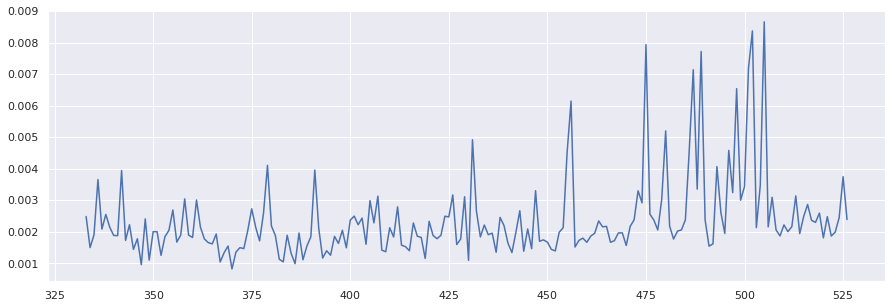

In [65]:
#Cycle through all positions, calculate JSD between results_Variant and result_mutant at each position
import scipy

jsd_Eta = []
columns=[]

for column in result_Eta:
    columns.append(column)
    jsd_Eta.append(JSD((result_Eta[column]),(result_mut[column])))
    
plt.plot(columns,jsd_Eta)

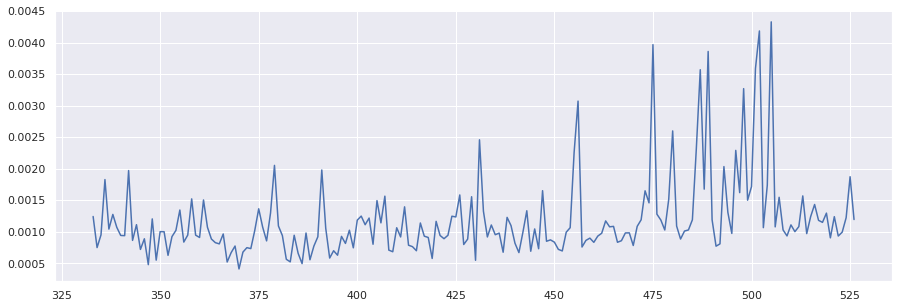

In [66]:
#Cycle through all positions, calculate JSD between results_Variant and result_mutant at each position
import scipy

jsd_Eta = []
columns=[]

for column in result_Eta:
    columns.append(column)
    jsd_Eta.append(scipy.spatial.distance.jensenshannon((result_Eta[column]),(result_mut[column])))
    
plt.plot(columns,jsd_Eta)